In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 37434 
    Total predicted counts          : 37266.54
    Total off counts                : 101703.00

    Total background counts         : 20340.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.30

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 2000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 11.5 s, sys: 83 ms, total: 11.6 s
Wall time: 11.6 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 37107 
    Total predicted counts          : 37257.94
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.87

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 36990 
    Total predicted counts          : 37192.34
    Total off counts                : 101332.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_18 

    Total counts                    : 37494 
    Total predicted counts          : 37259.34
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_19 

    Total counts                    : 37002 
    Total predicted counts          : 37212.94
    Total off counts                : 101435.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_39 

    Total counts                    : 37445 
    Total predicted counts          : 37192.34
    Total off counts                : 101332.00

    Total background counts         : 20266.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.31

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_40 

    Total counts                    : 37491 
    Total predicted counts          : 37304.54
    Total off counts                : 101893.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_60 

    Total counts                    : 37197 
    Total predicted counts          : 37244.94
    Total off counts                : 101595.00

    Total background counts         : 20319.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.86

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_61 

    Total counts                    : 37669 
    Total predicted counts          : 37092.74
    Total off counts                : 100834.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_81 

    Total counts                    : 37431 
    Total predicted counts          : 37125.34
    Total off counts                : 100997.00

    Total background counts         : 20199.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.31

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_82 

    Total counts                    : 36944 
    Total predicted counts          : 37224.54
    Total off counts                : 101493.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_103 

    Total counts                    : 37227 
    Total predicted counts          : 37227.34
    Total off counts                : 101507.00

    Total background counts         : 20301.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.41

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_104 

    Total counts                    : 36937 
    Total predicted counts          : 37317.54
    Total off counts                : 101958.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_127 

    Total counts                    : 36967 
    Total predicted counts          : 37258.54
    Total off counts                : 101663.00

    Total background counts         : 20332.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.15

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_128 

    Total counts                    : 37325 
    Total predicted counts          : 37227.14
    Total off counts                : 101506.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_149 

    Total counts                    : 37389 
    Total predicted counts          : 37178.54
    Total off counts                : 101263.00

    Total background counts         : 20252.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.29

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_150 

    Total counts                    : 37089 
    Total predicted counts          : 37235.54
    Total off counts                : 101548.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_171 

    Total counts                    : 37388 
    Total predicted counts          : 37280.74
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.91

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_172 

    Total counts                    : 36907 
    Total predicted counts          : 37255.34
    Total off counts                : 101647.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_193 

    Total counts                    : 37148 
    Total predicted counts          : 37261.14
    Total off counts                : 101676.00

    Total background counts         : 20335.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.19

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_194 

    Total counts                    : 37072 
    Total predicted counts          : 37257.54
    Total off counts                : 101658.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_215 

    Total counts                    : 37038 
    Total predicted counts          : 37304.34
    Total off counts                : 101892.00

    Total background counts         : 20378.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.81

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_216 

    Total counts                    : 37142 
    Total predicted counts          : 37199.94
    Total off counts                : 101370.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_237 

    Total counts                    : 37267 
    Total predicted counts          : 37192.14
    Total off counts                : 101331.00

    Total background counts         : 20266.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.22

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_238 

    Total counts                    : 36966 
    Total predicted counts          : 37201.54
    Total off counts                : 101378.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_259 

    Total counts                    : 37469 
    Total predicted counts          : 37183.54
    Total off counts                : 101288.00

    Total background counts         : 20257.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.96

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_260 

    Total counts                    : 37013 
    Total predicted counts          : 37196.74
    Total off counts                : 101354.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_281 

    Total counts                    : 37035 
    Total predicted counts          : 37248.94
    Total off counts                : 101615.00

    Total background counts         : 20323.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.45

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_282 

    Total counts                    : 37203 
    Total predicted counts          : 37266.54
    Total off counts                : 101703.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_302 

    Total counts                    : 37066 
    Total predicted counts          : 37158.14
    Total off counts                : 101161.00

    Total background counts         : 20232.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.15

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_303 

    Total counts                    : 37174 
    Total predicted counts          : 37301.94
    Total off counts                : 101880.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_323 

    Total counts                    : 37341 
    Total predicted counts          : 37192.74
    Total off counts                : 101334.00

    Total background counts         : 20266.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.69

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_324 

    Total counts                    : 37104 
    Total predicted counts          : 37319.94
    Total off counts                : 101970.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_345 

    Total counts                    : 37307 
    Total predicted counts          : 37327.94
    Total off counts                : 102010.00

    Total background counts         : 20402.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.40

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_346 

    Total counts                    : 37354 
    Total predicted counts          : 37224.34
    Total off counts                : 101492.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_367 

    Total counts                    : 36850 
    Total predicted counts          : 37131.14
    Total off counts                : 101026.00

    Total background counts         : 20205.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.76

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_368 

    Total counts                    : 37255 
    Total predicted counts          : 37097.34
    Total off counts                : 100857.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_389 

    Total counts                    : 37046 
    Total predicted counts          : 37179.14
    Total off counts                : 101266.00

    Total background counts         : 20253.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.29

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_390 

    Total counts                    : 37001 
    Total predicted counts          : 37240.74
    Total off counts                : 101574.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_411 

    Total counts                    : 37462 
    Total predicted counts          : 37364.34
    Total off counts                : 102192.00

    Total background counts         : 20438.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.51

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_412 

    Total counts                    : 37335 
    Total predicted counts          : 37197.74
    Total off counts                : 101359.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_433 

    Total counts                    : 37225 
    Total predicted counts          : 37255.14
    Total off counts                : 101646.00

    Total background counts         : 20329.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.06

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_434 

    Total counts                    : 37223 
    Total predicted counts          : 37166.74
    Total off counts                : 101204.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_455 

    Total counts                    : 37225 
    Total predicted counts          : 37209.34
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.81

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_456 

    Total counts                    : 37256 
    Total predicted counts          : 37189.94
    Total off counts                : 101320.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_476 

    Total counts                    : 37090 
    Total predicted counts          : 37242.34
    Total off counts                : 101582.00

    Total background counts         : 20316.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.65

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_477 

    Total counts                    : 37346 
    Total predicted counts          : 37291.34
    Total off counts                : 101827.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_497 

    Total counts                    : 37062 
    Total predicted counts          : 37289.74
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.00

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_498 

    Total counts                    : 37190 
    Total predicted counts          : 37223.94
    Total off counts                : 101490.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_517 

    Total counts                    : 37123 
    Total predicted counts          : 37292.14
    Total off counts                : 101831.00

    Total background counts         : 20366.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.72

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_518 

    Total counts                    : 36929 
    Total predicted counts          : 37261.74
    Total off counts                : 101679.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_538 

    Total counts                    : 37320 
    Total predicted counts          : 37284.14
    Total off counts                : 101791.00

    Total background counts         : 20358.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.74

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_539 

    Total counts                    : 36810 
    Total predicted counts          : 37146.34
    Total off counts                : 101102.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_558 

    Total counts                    : 37147 
    Total predicted counts          : 37332.94
    Total off counts                : 102035.00

    Total background counts         : 20407.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.66

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_559 

    Total counts                    : 37381 
    Total predicted counts          : 37281.34
    Total off counts                : 101777.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_578 

    Total counts                    : 37510 
    Total predicted counts          : 37308.34
    Total off counts                : 101912.00

    Total background counts         : 20382.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.66

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_579 

    Total counts                    : 36986 
    Total predicted counts          : 37236.54
    Total off counts                : 101553.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_598 

    Total counts                    : 37579 
    Total predicted counts          : 37349.14
    Total off counts                : 102116.00

    Total background counts         : 20423.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.53

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_599 

    Total counts                    : 37161 
    Total predicted counts          : 37264.94
    Total off counts                : 101695.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_619 

    Total counts                    : 37377 
    Total predicted counts          : 37271.14
    Total off counts                : 101726.00

    Total background counts         : 20345.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.16

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_620 

    Total counts                    : 37268 
    Total predicted counts          : 37297.34
    Total off counts                : 101857.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_639 

    Total counts                    : 37536 
    Total predicted counts          : 37252.14
    Total off counts                : 101631.00

    Total background counts         : 20326.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.13

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_640 

    Total counts                    : 37167 
    Total predicted counts          : 37217.54
    Total off counts                : 101458.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_659 

    Total counts                    : 37364 
    Total predicted counts          : 37230.34
    Total off counts                : 101522.00

    Total background counts         : 20304.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.28

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_660 

    Total counts                    : 37430 
    Total predicted counts          : 37288.54
    Total off counts                : 101813.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_680 

    Total counts                    : 37258 
    Total predicted counts          : 37137.74
    Total off counts                : 101059.00

    Total background counts         : 20211.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.25

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_681 

    Total counts                    : 37413 
    Total predicted counts          : 37161.74
    Total off counts                : 101179.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_700 

    Total counts                    : 37190 
    Total predicted counts          : 37267.54
    Total off counts                : 101708.00

    Total background counts         : 20341.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.83

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_701 

    Total counts                    : 37478 
    Total predicted counts          : 37200.34
    Total off counts                : 101372.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_721 

    Total counts                    : 37038 
    Total predicted counts          : 37302.94
    Total off counts                : 101885.00

    Total background counts         : 20377.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_722 

    Total counts                    : 37059 
    Total predicted counts          : 37130.74
    Total off counts                : 101024.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_742 

    Total counts                    : 37321 
    Total predicted counts          : 37270.94
    Total off counts                : 101725.00

    Total background counts         : 20345.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.24

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_743 

    Total counts                    : 36937 
    Total predicted counts          : 37007.74
    Total off counts                : 100409.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_762 

    Total counts                    : 37056 
    Total predicted counts          : 37229.14
    Total off counts                : 101516.00

    Total background counts         : 20303.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.19

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_763 

    Total counts                    : 37237 
    Total predicted counts          : 37310.54
    Total off counts                : 101923.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_782 

    Total counts                    : 37156 
    Total predicted counts          : 37209.14
    Total off counts                : 101416.00

    Total background counts         : 20283.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.33

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_783 

    Total counts                    : 37257 
    Total predicted counts          : 37285.54
    Total off counts                : 101798.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_802 

    Total counts                    : 37299 
    Total predicted counts          : 37249.14
    Total off counts                : 101616.00

    Total background counts         : 20323.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.49

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_803 

    Total counts                    : 37263 
    Total predicted counts          : 37216.34
    Total off counts                : 101452.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_823 

    Total counts                    : 37387 
    Total predicted counts          : 37214.74
    Total off counts                : 101444.00

    Total background counts         : 20288.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 22.44

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_824 

    Total counts                    : 37295 
    Total predicted counts          : 37216.34
    Total off counts                : 101452.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_843 

    Total counts                    : 36885 
    Total predicted counts          : 37201.54
    Total off counts                : 101378.00

    Total background counts         : 20275.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.57

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_844 

    Total counts                    : 37163 
    Total predicted counts          : 37185.14
    Total off counts                : 101296.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_864 

    Total counts                    : 36966 
    Total predicted counts          : 37289.34
    Total off counts                : 101817.00

    Total background counts         : 20363.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.59

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_865 

    Total counts                    : 36902 
    Total predicted counts          : 37232.94
    Total off counts                : 101535.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_884 

    Total counts                    : 37279 
    Total predicted counts          : 37148.34
    Total off counts                : 101112.00

    Total background counts         : 20222.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.58

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_885 

    Total counts                    : 36770 
    Total predicted counts          : 37238.34
    Total off counts                : 101562.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_906 

    Total counts                    : 37506 
    Total predicted counts          : 37231.94
    Total off counts                : 101530.00

    Total background counts         : 20306.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.04

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_907 

    Total counts                    : 37162 
    Total predicted counts          : 37253.74
    Total off counts                : 101639.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_927 

    Total counts                    : 37264 
    Total predicted counts          : 37085.34
    Total off counts                : 100797.00

    Total background counts         : 20159.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.83

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_928 

    Total counts                    : 37247 
    Total predicted counts          : 37226.54
    Total off counts                : 101503.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_948 

    Total counts                    : 37086 
    Total predicted counts          : 37205.14
    Total off counts                : 101396.00

    Total background counts         : 20279.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.95

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_949 

    Total counts                    : 36983 
    Total predicted counts          : 37222.94
    Total off counts                : 101485.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_969 

    Total counts                    : 37287 
    Total predicted counts          : 37230.54
    Total off counts                : 101523.00

    Total background counts         : 20304.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.94

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_970 

    Total counts                    : 37471 
    Total predicted counts          : 37243.74
    Total off counts                : 101589.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_990 

    Total counts                    : 36962 
    Total predicted counts          : 37146.74
    Total off counts                : 101104.00

    Total background counts         : 20220.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.75

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_991 

    Total counts                    : 37822 
    Total predicted counts          : 37224.54
    Total off counts                : 101493.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_1012 

    Total counts                    : 37417 
    Total predicted counts          : 37212.74
    Total off counts                : 101434.00

    Total background counts         : 20286.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.12

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1013 

    Total counts                    : 36873 
    Total predicted counts          : 37196.54
    Total off counts                : 101353.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1033 

    Total counts                    : 37201 
    Total predicted counts          : 37283.54
    Total off counts                : 101788.00

    Total background counts         : 20357.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.82

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1034 

    Total counts                    : 36988 
    Total predicted counts          : 37201.14
    Total off counts                : 101376.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1053 

    Total counts                    : 37139 
    Total predicted counts          : 37189.94
    Total off counts                : 101320.00

    Total background counts         : 20264.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.53

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1054 

    Total counts                    : 37295 
    Total predicted counts          : 37327.94
    Total off counts                : 102010.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1074 

    Total counts                    : 37450 
    Total predicted counts          : 37228.14
    Total off counts                : 101511.00

    Total background counts         : 20302.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.74

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1075 

    Total counts                    : 37172 
    Total predicted counts          : 37301.34
    Total off counts                : 101877.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1095 

    Total counts                    : 37142 
    Total predicted counts          : 37230.94
    Total off counts                : 101525.00

    Total background counts         : 20305.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.43

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1096 

    Total counts                    : 37185 
    Total predicted counts          : 37325.94
    Total off counts                : 102000.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1116 

    Total counts                    : 36866 
    Total predicted counts          : 37234.74
    Total off counts                : 101544.00

    Total background counts         : 20308.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.24

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1117 

    Total counts                    : 37251 
    Total predicted counts          : 37215.14
    Total off counts                : 101446.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1138 

    Total counts                    : 37692 
    Total predicted counts          : 37233.14
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.50

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1139 

    Total counts                    : 37487 
    Total predicted counts          : 37277.54
    Total off counts                : 101758.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1160 

    Total counts                    : 36960 
    Total predicted counts          : 37119.14
    Total off counts                : 100966.00

    Total background counts         : 20193.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.36

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1161 

    Total counts                    : 37251 
    Total predicted counts          : 37250.34
    Total off counts                : 101622.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1180 

    Total counts                    : 37023 
    Total predicted counts          : 37312.14
    Total off counts                : 101931.00

    Total background counts         : 20386.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1181 

    Total counts                    : 37177 
    Total predicted counts          : 37153.14
    Total off counts                : 101136.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1201 

    Total counts                    : 37221 
    Total predicted counts          : 37223.74
    Total off counts                : 101489.00

    Total background counts         : 20297.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.64

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1202 

    Total counts                    : 37055 
    Total predicted counts          : 37241.94
    Total off counts                : 101580.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1222 

    Total counts                    : 37142 
    Total predicted counts          : 37348.34
    Total off counts                : 102112.00

    Total background counts         : 20422.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.64

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1223 

    Total counts                    : 37312 
    Total predicted counts          : 37271.34
    Total off counts                : 101727.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1243 

    Total counts                    : 37196 
    Total predicted counts          : 37324.14
    Total off counts                : 101991.00

    Total background counts         : 20398.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.11

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1244 

    Total counts                    : 37459 
    Total predicted counts          : 37232.94
    Total off counts                : 101535.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1264 

    Total counts                    : 37245 
    Total predicted counts          : 37253.94
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.02

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1265 

    Total counts                    : 37283 
    Total predicted counts          : 37304.94
    Total off counts                : 101895.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1285 

    Total counts                    : 36979 
    Total predicted counts          : 37234.34
    Total off counts                : 101542.00

    Total background counts         : 20308.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.36

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1286 

    Total counts                    : 37228 
    Total predicted counts          : 37282.74
    Total off counts                : 101784.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1306 

    Total counts                    : 37406 
    Total predicted counts          : 37271.74
    Total off counts                : 101729.00

    Total background counts         : 20345.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.92

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1307 

    Total counts                    : 36889 
    Total predicted counts          : 37347.54
    Total off counts                : 102108.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1327 

    Total counts                    : 37217 
    Total predicted counts          : 37238.74
    Total off counts                : 101564.00

    Total background counts         : 20312.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.23

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1328 

    Total counts                    : 37312 
    Total predicted counts          : 37317.74
    Total off counts                : 101959.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1348 

    Total counts                    : 37547 
    Total predicted counts          : 37245.34
    Total off counts                : 101597.00

    Total background counts         : 20319.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.79

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1349 

    Total counts                    : 36964 
    Total predicted counts          : 37255.94
    Total off counts                : 101650.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1369 

    Total counts                    : 36973 
    Total predicted counts          : 37280.14
    Total off counts                : 101771.00

    Total background counts         : 20354.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.38

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1370 

    Total counts                    : 37026 
    Total predicted counts          : 37226.94
    Total off counts                : 101505.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1390 

    Total counts                    : 37252 
    Total predicted counts          : 37140.54
    Total off counts                : 101073.00

    Total background counts         : 20214.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.25

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1391 

    Total counts                    : 37443 
    Total predicted counts          : 37323.74
    Total off counts                : 101989.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1412 

    Total counts                    : 37400 
    Total predicted counts          : 37241.34
    Total off counts                : 101577.00

    Total background counts         : 20315.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.78

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1413 

    Total counts                    : 36963 
    Total predicted counts          : 37254.74
    Total off counts                : 101644.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1435 

    Total counts                    : 37405 
    Total predicted counts          : 37282.34
    Total off counts                : 101782.00

    Total background counts         : 20356.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.57

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1436 

    Total counts                    : 37540 
    Total predicted counts          : 37302.54
    Total off counts                : 101883.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1456 

    Total counts                    : 37406 
    Total predicted counts          : 37199.74
    Total off counts                : 101369.00

    Total background counts         : 20273.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.20

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1457 

    Total counts                    : 37081 
    Total predicted counts          : 37228.74
    Total off counts                : 101514.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1477 

    Total counts                    : 37365 
    Total predicted counts          : 37219.54
    Total off counts                : 101468.00

    Total background counts         : 20293.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.71

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1478 

    Total counts                    : 37447 
    Total predicted counts          : 37265.74
    Total off counts                : 101699.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1498 

    Total counts                    : 37532 
    Total predicted counts          : 37141.94
    Total off counts                : 101080.00

    Total background counts         : 20216.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.12

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1499 

    Total counts                    : 37289 
    Total predicted counts          : 37276.54
    Total off counts                : 101753.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1519 

    Total counts                    : 36975 
    Total predicted counts          : 37255.74
    Total off counts                : 101649.00

    Total background counts         : 20329.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.34

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1520 

    Total counts                    : 37235 
    Total predicted counts          : 37310.54
    Total off counts                : 101923.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1540 

    Total counts                    : 37520 
    Total predicted counts          : 37255.94
    Total off counts                : 101650.00

    Total background counts         : 20330.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.04

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1541 

    Total counts                    : 37107 
    Total predicted counts          : 37252.94
    Total off counts                : 101635.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1566 

    Total counts                    : 37332 
    Total predicted counts          : 37211.74
    Total off counts                : 101429.00

    Total background counts         : 20285.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.36

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1567 

    Total counts                    : 37182 
    Total predicted counts          : 37253.14
    Total off counts                : 101636.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1592 

    Total counts                    : 37361 
    Total predicted counts          : 37044.34
    Total off counts                : 100592.00

    Total background counts         : 20118.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.16

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1593 

    Total counts                    : 37362 
    Total predicted counts          : 37284.54
    Total off counts                : 101793.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1625 

    Total counts                    : 37318 
    Total predicted counts          : 37336.34
    Total off counts                : 102052.00

    Total background counts         : 20410.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.56

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1626 

    Total counts                    : 37170 
    Total predicted counts          : 37166.74
    Total off counts                : 101204.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1657 

    Total counts                    : 37302 
    Total predicted counts          : 37251.14
    Total off counts                : 101626.00

    Total background counts         : 20325.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.05

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1658 

    Total counts                    : 36974 
    Total predicted counts          : 37224.54
    Total off counts                : 101493.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1687 

    Total counts                    : 37383 
    Total predicted counts          : 37191.94
    Total off counts                : 101330.00

    Total background counts         : 20266.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.73

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1688 

    Total counts                    : 37113 
    Total predicted counts          : 37268.14
    Total off counts                : 101711.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1718 

    Total counts                    : 37042 
    Total predicted counts          : 37231.34
    Total off counts                : 101527.00

    Total background counts         : 20305.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.22

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1719 

    Total counts                    : 37167 
    Total predicted counts          : 37220.34
    Total off counts                : 101472.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1750 

    Total counts                    : 37545 
    Total predicted counts          : 37232.94
    Total off counts                : 101535.00

    Total background counts         : 20307.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.61

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1751 

    Total counts                    : 36930 
    Total predicted counts          : 37277.14
    Total off counts                : 101756.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1779 

    Total counts                    : 37144 
    Total predicted counts          : 37175.14
    Total off counts                : 101246.00

    Total background counts         : 20249.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.04

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1780 

    Total counts                    : 36890 
    Total predicted counts          : 37251.14
    Total off counts                : 101626.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1812 

    Total counts                    : 37419 
    Total predicted counts          : 37218.94
    Total off counts                : 101465.00

    Total background counts         : 20293.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.50

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1813 

    Total counts                    : 37024 
    Total predicted counts          : 37214.94
    Total off counts                : 101445.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1835 

    Total counts                    : 37230 
    Total predicted counts          : 37214.74
    Total off counts                : 101444.00

    Total background counts         : 20288.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.77

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1836 

    Total counts                    : 37450 
    Total predicted counts          : 37263.94
    Total off counts                : 101690.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1869 

    Total counts                    : 37258 
    Total predicted counts          : 37216.74
    Total off counts                : 101454.00

    Total background counts         : 20290.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.70

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1870 

    Total counts                    : 37344 
    Total predicted counts          : 37231.74
    Total off counts                : 101529.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1903 

    Total counts                    : 37211 
    Total predicted counts          : 37225.74
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.14

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1904 

    Total counts                    : 37465 
    Total predicted counts          : 37147.74
    Total off counts                : 101109.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1936 

    Total counts                    : 37343 
    Total predicted counts          : 37379.14
    Total off counts                : 102266.00

    Total background counts         : 20453.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.95

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1937 

    Total counts                    : 37344 
    Total predicted counts          : 37253.34
    Total off counts                : 101637.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1970 

    Total counts                    : 37242 
    Total predicted counts          : 37189.54
    Total off counts                : 101318.00

    Total background counts         : 20263.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.92

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1971 

    Total counts                    : 37055 
    Total predicted counts          : 37253.74
    Total off counts                : 101639.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1998 

    Total counts                    : 37313 
    Total predicted counts          : 37247.74
    Total off counts                : 101609.00

    Total background counts         : 20321.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.37

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1999 

    Total counts                    : 37349 
    Total predicted counts          : 37256.54
    Total off counts                : 101653.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

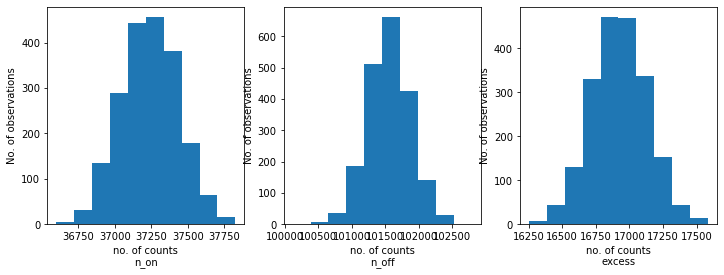

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )

CPU times: user 2min 59s, sys: 542 ms, total: 2min 59s
Wall time: 2min 59s


In [15]:
results

[{'index': 2.210312649457622, 'amplitude': 1.2999148010805192e-12},
 {'index': 2.221794649297089, 'amplitude': 1.2624720633438962e-12},
 {'index': 2.226917472297916, 'amplitude': 1.2692828741968535e-12},
 {'index': 2.2243294724809273, 'amplitude': 1.2760460667160836e-12},
 {'index': 2.230487848445283, 'amplitude': 1.289071814190189e-12},
 {'index': 2.2176425247166542, 'amplitude': 1.2822089037710306e-12},
 {'index': 2.216192794914367, 'amplitude': 1.2905649230744224e-12},
 {'index': 2.2181788794836295, 'amplitude': 1.2844505300569238e-12},
 {'index': 2.2148364595219476, 'amplitude': 1.2941866637630027e-12},
 {'index': 2.2099732084774226, 'amplitude': 1.3004987871954154e-12},
 {'index': 2.2172085439732427, 'amplitude': 1.3021990683930246e-12},
 {'index': 2.2163893701043262, 'amplitude': 1.3029965681849181e-12},
 {'index': 2.2152326224488714, 'amplitude': 1.3060639898614054e-12},
 {'index': 2.218580088362964, 'amplitude': 1.2638387722092008e-12},
 {'index': 2.216428727442129, 'amplitude'

index: 2.2201504659938367 += 0.006490796423335198


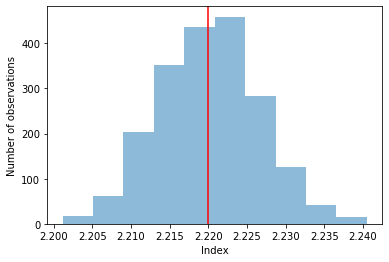

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2888380739569502e-12 += 1.430448060234054e-14


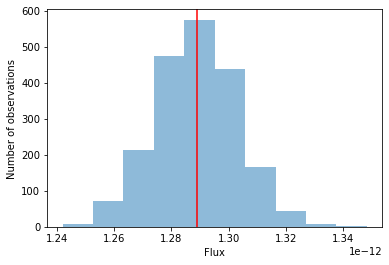

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")